# Pandas example

CPBS 7601

1. Import packages and setup options
2. Load data
3. Clean data
4. Wrangle data
5. Outputs

## Step 1 - Import packages and setup options

In [1]:
import pathlib
import numpy as np
import pandas as pd
import scipy.stats as stats
import plotnine as gg

In [2]:
# Set constants and paths
figshare_base_url = "https://figshare.com/ndownloader/files/"

drug_screen_file_id = "46630984"
drug_id_file_id = "46630981"
cellline_file_id = "46630978"

# Set output file paths
output_directory = "results"
ttest_results_file = pathlib.Path(output_directory, "ttest_results_pandas.csv")
volcano_plot_file = pathlib.Path(output_directory, "volcano_plot_pandas.png")

## Step 2 - Load the data

1. Drug screening viability data
2. Drug identifier metadata
3. Cell line identifier metadata

Accessed from the DepMap Drug Repurposing Hub 2024 2Q Data Release.

https://figshare.com/articles/dataset/Repurposing_Public_24Q2/25917643/1?file=46630978

In [3]:
# Load drug screen data
drug_screen_results_df = pd.read_csv(f"{figshare_base_url}{drug_screen_file_id}")

# Explore the data
print(drug_screen_results_df.shape)
drug_screen_results_df.head(3)

(6790, 920)


,Unnamed: 0,ACH-000001,ACH-000002,ACH-000004,ACH-000005,ACH-000006,ACH-000007,ACH-000008,ACH-000010,ACH-000011,...,ACH-002016,ACH-002022,ACH-002023,ACH-002025,ACH-002038,ACH-002039,ACH-002041,ACH-002042,ACH-002046,ACH-002048
0,BRD:BRD-A00047421-001-01-7,-1.207281,-4.231563,-3.860672,-2.271411,0.277833,-4.011285,-0.615105,-2.6253,-1.827661,...,-1.975287,-2.403487,-0.495741,-3.238121,1.223419,-2.314389,-2.805922,-2.332483,-3.441262,-1.254407
1,BRD:BRD-A00055058-001-01-0,0.515743,NaN,NaN,NaN,NaN,0.196878,0.347821,NaN,-0.001031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BRD:BRD-A00077618-236-07-6,-0.015577,NaN,NaN,NaN,NaN,-0.095730,0.379480,NaN,0.145346,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Load compound identifier metadata
compound_id_df = pd.read_csv(f"{figshare_base_url}{drug_id_file_id}")

# Explore the data
print(compound_id_df.shape)
compound_id_df.head(3)

(6790, 7)


,screen,dose,repurposing_target,MOA,IDs,Drug.Name,Synonyms
0,REP.300,2.5,NaN,NaN,BRD:BRD-K00104122-001-01-9,MRTX1133,MRTX1133
1,REP.300,2.5,NaN,NaN,BRD:BRD-K00104124-001-01-9,PEMIGATINIB,PEMIGATINIB
2,REP.300,2.5,NaN,NaN,BRD:BRD-K00085355-001-01-9,TELAVANCIN,TELAVANCIN


In [5]:
# Load compound identifier metadata
cellline_id_df = pd.read_csv(f"{figshare_base_url}{cellline_file_id}")

# Explore the data
print(cellline_id_df.shape)
cellline_id_df.head(3)

(1898, 6)


,ccle_name,row_id,pool_id,culture,depmap_id,screen
0,KYSE510_OESOPHAGUS,ACH-000824::P107::PR500A::REP1M,P107,PR500A,ACH-000824,REP1M
1,HEC1A_ENDOMETRIUM,ACH-000954::P107::PR500A::REP1M,P107,PR500A,ACH-000954,REP1M
2,MIAPACA2_PANCREAS,ACH-000601::P101::PR500A::REP1M,P101,PR500A,ACH-000601,REP1M


## Step 3 - Clean data

It's extremely rare for a dataset to not need any cleaning.

Chances are that you will need to fix some column names, isolate certain rows and/or columns for your analysis, remove certain data, and perform other operations to get your data ready for analysis.

Here, we perform a series of data cleaning operations.

Note, that we would have done much of this data cleaning upon data loading, but, for instruction, we do it separately here.

In [6]:
## Step 1 - Rename column 1
drug_screen_results_df = (
    drug_screen_results_df
    .rename(columns={"Unnamed: 0": "BRD_ID"})
)

## Step 2 - Select drugs with known MOA
compounds_with_known_MOA = (
    compound_id_df
    .dropna(subset="MOA")
    .IDs
    .unique()
)

# Step 3 - Filter drug screen data to only include compounds with known MOA
drug_screen_results_df = (
    drug_screen_results_df
    .loc[lambda x: x.BRD_ID.isin(compounds_with_known_MOA)]
)

# Step 4 - Split cell line column to separate name from cancer type
# and keep only certain columns
cellline_id_df = (
    pd.concat([
      cellline_id_df.drop(columns=["ccle_name"]),
      pd.DataFrame(
          cellline_id_df
          .ccle_name
          .str
          .split("_", n=1)
          .tolist(),
          columns=["cell_line", "cancer_type"]
        )
  ], axis=1
  )
  .loc[:, ["cell_line", "cancer_type", "depmap_id"]]
  .drop_duplicates()
)

# Step 5 - Remove screen and dose columns in drug id data
compound_id_df = (
    compound_id_df
    .drop(columns=["screen", "dose"])
    .drop_duplicates()
)

## Step 4: Wrangle data

Data are always in an inappropriate form for analysis.

Wrangling data get data in the correct form so that you can apply statistics and machine learning.

In [7]:
# Filter drug screen data to only include data from pancreatic and liver cancers
select_cancer_types = ["PANCREAS", "LIVER"]

select_cancer_depmap_ids = (
    cellline_id_df
    .loc[cellline_id_df["cancer_type"].isin(select_cancer_types), "depmap_id"]
    .tolist()
)

drug_screen_results_df = (
    drug_screen_results_df
    .loc[:, ["BRD_ID"] + select_cancer_depmap_ids]
)

print(drug_screen_results_df.shape)
drug_screen_results_df.head(3)

(6114, 65)


,BRD_ID,ACH-000601,ACH-000361,ACH-001318,ACH-000332,ACH-000476,ACH-000178,ACH-000108,ACH-000164,ACH-000217,...,ACH-000475,ACH-000483,ACH-000739,ACH-000093,ACH-000213,ACH-000686,ACH-000094,ACH-002039,ACH-001379,ACH-001353
0,BRD:BRD-A00047421-001-01-7,-5.247520,-2.774197,-0.561734,-0.170779,-1.722211,-0.489995,-1.527341,-4.409369,-1.359761,...,-1.836582,-5.571624,-2.085553,-3.714173,-3.722602,NaN,-4.947453,-2.314389,-3.16745,-0.152534
1,BRD:BRD-A00055058-001-01-0,0.079117,0.212967,-0.039683,-0.159559,0.213342,-0.093341,-0.239580,0.145756,0.097425,...,0.169494,-0.160122,-0.147668,-0.181681,-0.004215,0.29274,NaN,NaN,NaN,NaN
2,BRD:BRD-A00077618-236-07-6,0.184965,-0.604188,-0.012480,-0.004607,-0.086193,0.432705,0.265263,0.389400,0.545591,...,-0.163159,-0.294865,0.398403,NaN,0.306107,NaN,NaN,NaN,NaN,NaN


In [8]:
# Pivot wide data to long data
drug_screen_results_long_df = (
    drug_screen_results_df
    .melt(
        id_vars=["BRD_ID"],
        value_name="response",
        var_name="ach_cell_line_id"
        )
)

print(drug_screen_results_long_df.shape)
drug_screen_results_long_df.head(3)

(391296, 3)


,BRD_ID,ach_cell_line_id,response
0,BRD:BRD-A00047421-001-01-7,ACH-000601,-5.247520
1,BRD:BRD-A00055058-001-01-0,ACH-000601,0.079117
2,BRD:BRD-A00077618-236-07-6,ACH-000601,0.184965


In [9]:
# Join cell line metadata and drug identifiers
drug_screen_results_long_df = (
    drug_screen_results_long_df
    .merge(
        cellline_id_df,
        left_on="ach_cell_line_id",
        right_on="depmap_id",
        how="left"
    )
    .merge(
        compound_id_df,
        left_on="BRD_ID",
        right_on="IDs",
        how="left"
    )
    .drop_duplicates()
)

print(drug_screen_results_long_df.shape)
drug_screen_results_long_df.head(3)

(391296, 11)


,BRD_ID,ach_cell_line_id,response,cell_line,cancer_type,depmap_id,repurposing_target,MOA,IDs,Drug.Name,Synonyms
0,BRD:BRD-A00047421-001-01-7,ACH-000601,-5.247520,MIAPACA2,PANCREAS,ACH-000601,BRD4,BROMODOMAIN INHIBITOR,BRD:BRD-A00047421-001-01-7,ARV-825,ARV-825
1,BRD:BRD-A00055058-001-01-0,ACH-000601,0.079117,MIAPACA2,PANCREAS,ACH-000601,NaN,IMMUNOSTIMULANT,BRD:BRD-A00055058-001-01-0,RS-0481,RS-0481
2,BRD:BRD-A00077618-236-07-6,ACH-000601,0.184965,MIAPACA2,PANCREAS,ACH-000601,PRKG1,PKA ACTIVATOR,BRD:BRD-A00077618-236-07-6,8-BROMO-CGMP,8-BROMO-CGMP


## Step 5 - Outputs

We can now analyze the data in any number of ways.

We show here one example:

1. Identifying the most differentially effective MOAs between pancreatic and liver cancers.
2. Visualizing the results.

In [10]:
# Identify all unique MOAs
unique_MOAs = drug_screen_results_long_df.MOA.unique().tolist()

len(unique_MOAs)

1415

In [11]:
# Calculate t-test for each MOA across pancreatic and liver cancers
ttest_results = []
for moa in unique_MOAs:
    # Isolate specific moa
    specific_moa_drug_screen_results_long_df = (
        drug_screen_results_long_df
        .query("MOA == @moa")
    )
    
    # Collect specific responses according to cancer type
    pancreatic_response = (
        specific_moa_drug_screen_results_long_df
        .query("cancer_type == 'PANCREAS'")
    ).response.dropna().tolist()

    liver_response = (
        specific_moa_drug_screen_results_long_df
        .query("cancer_type == 'LIVER'")
    ).response.dropna().tolist()

    # Calculate t-test
    t_test_result = stats.ttest_ind(
        pancreatic_response,
        liver_response,
        nan_policy="omit",
        equal_var=False
        )

    # Store results
    ttest_results.append([
        moa,
        t_test_result.statistic,
        t_test_result.pvalue
    ])

# Combine results into a data frame
ttest_results_df = (
    pd.DataFrame(
        ttest_results,
        columns=["moa", "test_statistic", "p_value"]
    )
    .sort_values(by="test_statistic", ascending=False)
    .reset_index(drop=True)
)

# Convert column types
ttest_results_df.test_statistic.t = ttest_results_df.test_statistic.astype(float)
ttest_results_df.p_value = ttest_results_df.p_value.astype(float)
                                       
# Output results
ttest_results_df.to_csv(ttest_results_file, sep=",", index=False)

print(ttest_results_df.shape)
ttest_results_df.head(5)

(1415, 3)


,moa,test_statistic,p_value
0,HDAC INHIBITOR,7.113728,1.636907e-12
1,MTOR INHIBITOR,4.773731,2.090123e-06
2,"DNA PROTEIN KINASE INHIBITOR, MTOR INHIBITOR",4.518397,9.821550e-05
3,MDM INHIBITOR,3.906045,1.136579e-04
4,TUBULIN POLYMERIZATION INHIBITOR,3.730575,2.006247e-04


/Users/waygr/miniforge3/envs/jupyter_conda_environment_cpbs7601/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 4 in image.
/Users/waygr/miniforge3/envs/jupyter_conda_environment_cpbs7601/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/volcano_plot_pandas.png


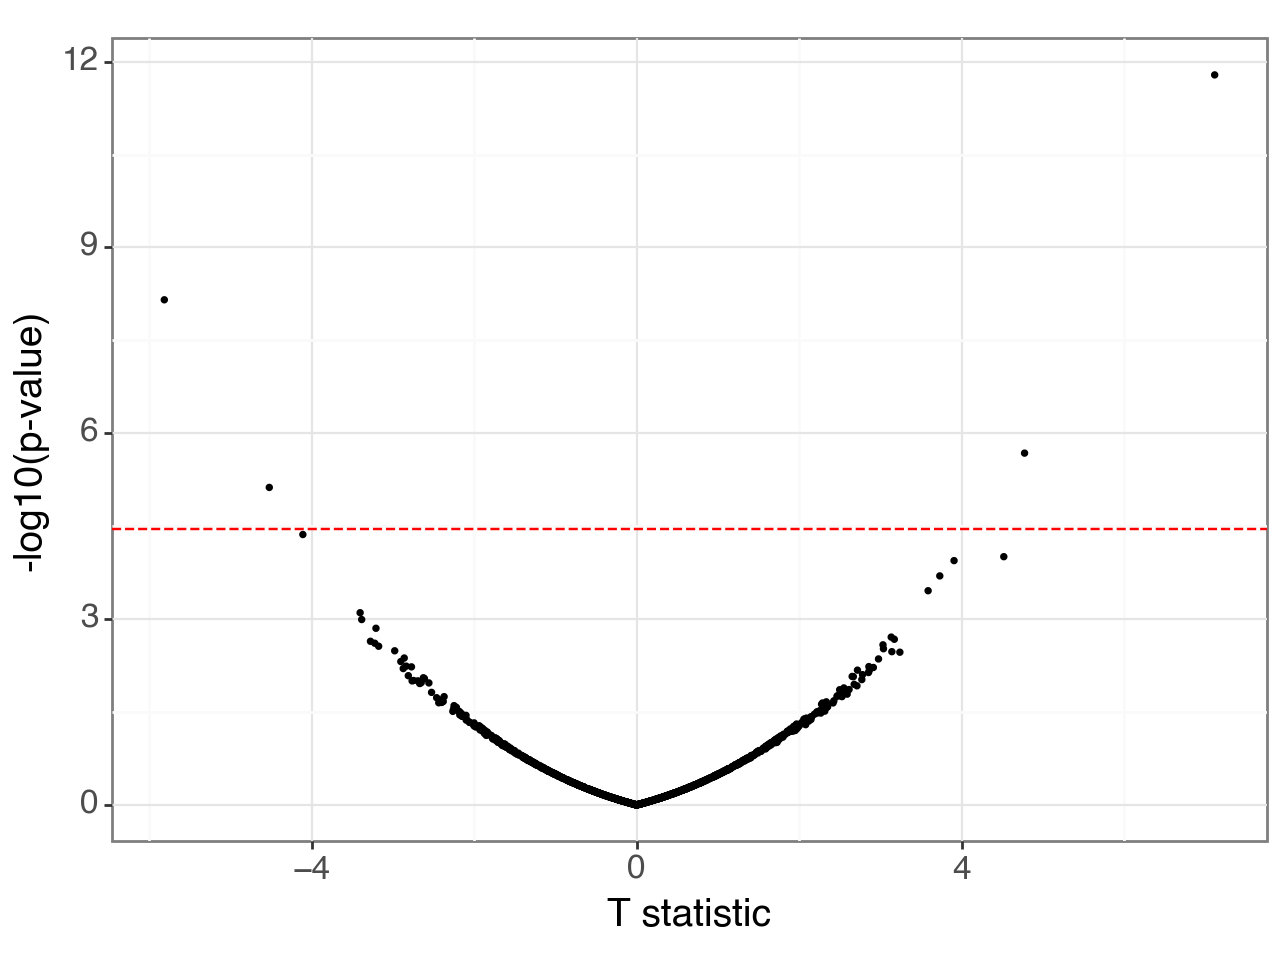

<Figure Size: (640 x 480)>

In [12]:
# Visualize results
bonferroni_adjusted_value = 0.05 / ttest_results_df.shape[0]

volcano_gg = (
    gg.ggplot(
        ttest_results_df,
        gg.aes(x="test_statistic", y="-np.log10(p_value)"),
        )
    + gg.geom_point(size = 0.5)
    + gg.geom_hline(
        yintercept=-np.log10(bonferroni_adjusted_value),
        linetype="dashed",
        color="red"
        )
    + gg.labs(x="T statistic", y="-log10(p-value)")
    + gg.theme_bw()
    + gg.theme(
        axis_title=gg.element_text(size=14),
        axis_text=gg.element_text(size=12)
        )
)

# Save plot
volcano_gg.save(volcano_plot_file, dpi=400, width=4, height=4)

volcano_gg